In [1]:
import logging

from imp import reload 
import numpy as np
import pandas as pd
import os
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. standard imports
import sys
import pathlib
sys.path.append('../src/')
sys.path.append('../../leankit/')

import leankit
from leankit import analytics_utils
# from leankit import ml_utils
from leankit import ffhs_utils

import make_dataset
# import regressions
import preprocess_dataset

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 2000)

C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\2753888309.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
DS_ASSESSMENTS = 'assessments'
DS_COURSES = 'courses'
DS_STUD_ASSESSMENTS = 'studentAssessment'
DS_STUD_INFO = 'studentInfo'
DS_STUD_REG = 'studentRegistration'
DS_STUD_VLE = 'studentVle'
DS_VLE = 'vle'

DS_ARRAY = [DS_ASSESSMENTS, DS_COURSES, DS_STUD_ASSESSMENTS, DS_STUD_INFO,
            DS_STUD_REG, DS_STUD_VLE, DS_VLE]

In [3]:
def plot_per_group(df, att = None, outcome="score", density=True):
    # outcome = 'pct_weeks_active_before_exam'
    groups = (df
        # .loc[lambda df_: df_.assessment_name == 'Exam']
        .groupby(['code_module','code_presentation','assessment_name'])
    )
    if outcome == 'score':
        bins = (10, 20, 30, 40, 50, 60, 70, 80, 90, 101)
    else:
        bins = (.1,.2,.3,.4,.5,.6,.7,.8,.9,1.01)
    fig, axes = plt.subplots(groups.ngroups,sharex=True, sharey=True, figsize=(10,18))
    for (g, grp), ax in zip(groups, axes.flatten()):
        if att is not None:
            grp = grp.groupby(att)
        grp[outcome].hist(density=density,
                                       bins=bins, 
                                    # bins=(10, 20, 30, 40, 50, 60, 70, 80, 90, 101),
                                    alpha=0.5,
                                    ax=ax, 
                                    legend=True);
        ax.set_title("-".join(str(x) for x in g))

# Load and Prepare Data

In [4]:
reload(make_dataset)
project_dir = pathlib.Path('../')
output_path = project_dir / 'data' / 'raw'
dfs_all = make_dataset.load_oulad(pickle_path="""C:\\Users\\martin.hlosta\\code\\compadv\\data\\raw""")
dfs_all = make_dataset.preprocess_oulad(dfs_all)

['assessments', 'courses', 'studentAssessment', 'studentInfo', 'studentRegistration', 'studentVle', 'vle']


In [5]:
reload(preprocess_dataset)
dfs = dfs_all

banked = dfs[DS_STUD_ASSESSMENTS][dfs[DS_STUD_ASSESSMENTS].is_banked > 0].id_student
ass = dfs[DS_ASSESSMENTS]
stud_ass = (dfs[DS_STUD_ASSESSMENTS].reset_index()
    .merge(ass, on=['id_assessment'])
)
reg = dfs[DS_STUD_REG]

first_assessments = preprocess_dataset.get_first_assessment(ass)
# ass = preprocess_dataset.impute_ggg_weights(ass)
ocas = preprocess_dataset.compute_ocas(dfs[DS_STUD_ASSESSMENTS], ass)

demog = (dfs[DS_STUD_INFO]
         .reset_index()
         .merge(
             dfs[DS_STUD_INFO].groupby(['code_module','code_presentation']).studied_credits.min().rename('course_credits').reset_index()
         )
         .merge(dfs[DS_COURSES].reset_index())         
         .assign(credits_other = lambda df_: df_.studied_credits - df_.course_credits,
                 educ_band = lambda df_: preprocess_dataset.band_education(df_.highest_education),
                 region_band = lambda df_: preprocess_dataset.band_region(df_.region),
                 is_repeating = lambda df_: (df_.num_of_prev_attempts > 0).astype(int),
         )
         .merge(ocas, on=['id_student','code_module','code_presentation'], how='left')
         .set_index(['code_module','code_presentation','id_student']
        )
)


In [7]:
# (demog
#  .assign(
#      is_pass = lambda df_: df_.final_result.isin(['Pass','Distinction']),
#  )
#  .groupby(['code_module','code_presentation'])['is_pass'].mean().sort_values().round(2)
# )

In [6]:
vle_all = dfs[DS_STUD_VLE].reset_index().merge(dfs[DS_VLE].reset_index())
course_length = dfs[DS_COURSES].module_presentation_length.div(7).apply(math.ceil)
pct_weeks_active = preprocess_dataset.get_pct_weeks_active(
    vle_all, 
    max_weeks=course_length)

In [489]:
exams = (stud_ass
 .loc[lambda df_: df_.assessment_name == 'Exam']
 .merge(demog, left_on=['id_student','code_module','code_presentation'], 
        right_on=['id_student','code_module','code_presentation'], 
        # how='right'
        )
 .merge(reg, left_on=['id_student','code_module','code_presentation'], 
        right_on=['id_student','code_module','code_presentation'], 
        # how='right'
 )
 .drop(columns=['id_assessment','assessment_type','imd',
              #   'imd_2',
                'imd_3',
                # 'educ_band','region_band',
                # 'assessment_name',
                # 'date',
                'weight','date_unregistration'])
 .rename(columns={'date':'exam_cutoff', 'week':'exam_cutoff_week'})
 .assign(exam_cutoff = lambda df_: df_.exam_cutoff.fillna(df_.module_presentation_length)
            )
 .assign(exam_cutoff_week = lambda df_: df_.exam_cutoff_week.fillna(df_.module_presentation_length/7).apply(np.ceil).astype(int))
)

deadlines = exams[['code_module','code_presentation','exam_cutoff','exam_cutoff_week']].drop_duplicates().loc[lambda df_: df_.exam_cutoff_week > 0]
vle_all_exam = vle_all.merge(deadlines, on=['code_module','code_presentation']).loc[lambda df_: ~df_.id_student.isna()]

pct_weeks_active_before_exam = preprocess_dataset.get_pct_weeks_active(
    vle_all_exam.loc[lambda df_: df_.week <= df_.exam_cutoff_week], 
    max_weeks=course_length)

exams_prep = (exams
        .set_index(['code_module','code_presentation','id_student'])
        .assign(pct_weeks_active = pct_weeks_active).fillna(0)
        # .assign(pct_weeks_active_after_tma1 = pct_weeks_active_after_tma1).fillna(0)
        .assign(pct_weeks_active_before_exam = pct_weeks_active_before_exam).fillna(0)
        .assign(is_repeating = lambda df_: df_.is_repeating.map({0:'NEW', 1:'REPEATING'}))
        .assign(disability = lambda df_: df_.disability.map({'N':'Non-Disabled', 'Y':'Disabled'}))
        .assign(credits_other_band = lambda df_: pd.cut(
                  df_.credits_other, bins=[0, 1, 60, 600], right=False)
              )
        .reset_index()
        .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation,
                is_pass = lambda df_: df_.final_result.isin(['Pass','Distinction']),)
)

## Correlations

In [490]:
stud_cma_wide = (stud_ass
 .loc[lambda df_: df_.code_module.isin(['CCC','DDD'])]
 .loc[lambda df_: df_.assessment_type == 'CMA']
 .merge(exams_prep[['code_module','code_presentation','id_student',]], 
        on=['code_module','code_presentation','id_student'])
 .set_index(['code_module','code_presentation','id_student',
             'assessment_name',])
 ['score']
 .unstack()
 .reset_index()
#  .loc[lambda df_: df_['TMA 3'].isna()]
)

In [491]:
stud_tma_wide = (stud_ass
 .loc[lambda df_: df_.code_module.isin(['CCC','DDD'])]
 .loc[lambda df_: df_.assessment_type == 'TMA']
 .merge(exams_prep[['code_module','code_presentation','id_student',]], 
        on=['code_module','code_presentation','id_student'])
 .set_index(['code_module','code_presentation','id_student',
             'assessment_name',])
 ['score']
 .unstack()
 .reset_index()
#  .loc[lambda df_: df_['TMA 3'].isna()]
)

In [492]:
stud_course_all = (
    exams_prep
    .merge(stud_tma_wide, on=['code_module','code_presentation','id_student',])
    .merge(stud_cma_wide, on=['code_module','code_presentation','id_student',], how='left')
    .rename(columns = {'score':'exam','pct_weeks_active_before_exam':'pct_weeks_online'})
    .assign(age_band = lambda df_: df_.age_band.replace('55<=','35-55').str.replace('35-55','35+'))
)

In [493]:
# stud_course_all.mod_pres.value_counts()

In [494]:
stud_course_all.to_csv('../data/stud_course_all.csv', index=False)

In [11]:
(stud_course_all
        # .loc[lambda df_: df_.mod_pres == mod_pres]
        .groupby(['mod_pres','gender'])
        [[
          'ocas','exam'
          ]]
        .corr()
        #  ['exam']
        #  .unstack()['score']
        # .reset_index()
        .round(4)
        # .dropna(axis='index',how='all')
        # .dropna(axis='columns',how='all')
        ['exam']
        # 
        .loc[lambda df_: df_ < 1.0]
        .unstack().unstack()['ocas']
        # .style
        #     .format(precision=4)
        #     .background_gradient(axis=None, vmin=0, vmax=1, 
        #                          cmap="YlGnBu"
        #                          )
    )

gender,F,M
mod_pres,,
CCC_2014B,0.4853,0.6388
CCC_2014J,0.5779,0.6450
DDD_2013B,0.6268,0.6549
DDD_2013J,0.6514,0.5849
DDD_2014B,0.6626,0.6158
DDD_2014J,0.6486,0.6216


In [144]:

for mod_pres in stud_course_all.mod_pres.unique():
    print(mod_pres)
    display(stud_course_all
        .loc[lambda df_: df_.mod_pres == mod_pres]
        # .groupby(['mod_pres'])
        [['pct_weeks_online',
          # 'ocas',
        # 'is_pass',


        
          'exam','TMA 1','TMA 2','TMA 3','TMA 4','TMA 5','TMA 6']]
        .corr(method='spearman')
        #  ['pct_weeks_active_before_exam']
        #  .unstack()['score']
        # .reset_index()
        .round(2)
        .dropna(axis='index',how='all')
        .dropna(axis='columns',how='all')
        .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=0, vmax=1, 
                                 cmap="YlGnBu"
                                 )
    )

CCC_2014B


,pct_weeks_online,exam,TMA 1,TMA 2,TMA 3,TMA 4
pct_weeks_online,1.0000,0.3300,0.2700,0.3600,0.3500,0.3800
exam,0.3300,1.0000,0.6400,0.6200,0.7100,0.7300
TMA 1,0.2700,0.6400,1.0000,0.7000,0.6900,0.6500
TMA 2,0.3600,0.6200,0.7000,1.0000,0.7800,0.7200
TMA 3,0.3500,0.7100,0.6900,0.7800,1.0000,0.8100
TMA 4,0.3800,0.7300,0.6500,0.7200,0.8100,1.0000


CCC_2014J


,pct_weeks_online,exam,TMA 1,TMA 2,TMA 3,TMA 4
pct_weeks_online,1.0000,0.2800,0.3100,0.3800,0.3500,0.3900
exam,0.2800,1.0000,0.6300,0.6700,0.7400,0.6600
TMA 1,0.3100,0.6300,1.0000,0.7200,0.6900,0.6200
TMA 2,0.3800,0.6700,0.7200,1.0000,0.7900,0.7200
TMA 3,0.3500,0.7400,0.6900,0.7900,1.0000,0.7900
TMA 4,0.3900,0.6600,0.6200,0.7200,0.7900,1.0000


DDD_2013B


,pct_weeks_online,exam,TMA 1,TMA 2,TMA 3,TMA 4,TMA 5,TMA 6
pct_weeks_online,1.0000,0.2200,0.1600,0.2700,0.2400,0.2500,0.2800,0.3000
exam,0.2200,1.0000,0.4900,0.4800,0.5000,0.5900,0.5700,0.6000
TMA 1,0.1600,0.4900,1.0000,0.6300,0.6000,0.5200,0.4400,0.5000
TMA 2,0.2700,0.4800,0.6300,1.0000,0.6400,0.5500,0.5400,0.5500
TMA 3,0.2400,0.5000,0.6000,0.6400,1.0000,0.6100,0.5600,0.5700
TMA 4,0.2500,0.5900,0.5200,0.5500,0.6100,1.0000,0.6600,0.6800
TMA 5,0.2800,0.5700,0.4400,0.5400,0.5600,0.6600,1.0000,0.6900
TMA 6,0.3000,0.6000,0.5000,0.5500,0.5700,0.6800,0.6900,1.0000


DDD_2013J


,pct_weeks_online,exam,TMA 1,TMA 2,TMA 3,TMA 4,TMA 5,TMA 6
pct_weeks_online,1.0000,0.3100,0.1700,0.3100,0.2400,0.2700,0.3300,0.2600
exam,0.3100,1.0000,0.4700,0.5000,0.5500,0.6500,0.5300,0.5800
TMA 1,0.1700,0.4700,1.0000,0.6400,0.6100,0.5300,0.4800,0.4900
TMA 2,0.3100,0.5000,0.6400,1.0000,0.6800,0.6100,0.6000,0.5600
TMA 3,0.2400,0.5500,0.6100,0.6800,1.0000,0.6500,0.5700,0.5700
TMA 4,0.2700,0.6500,0.5300,0.6100,0.6500,1.0000,0.6500,0.6500
TMA 5,0.3300,0.5300,0.4800,0.6000,0.5700,0.6500,1.0000,0.6400
TMA 6,0.2600,0.5800,0.4900,0.5600,0.5700,0.6500,0.6400,1.0000


DDD_2014B


,pct_weeks_online,exam,TMA 1,TMA 2,TMA 3,TMA 4,TMA 5,TMA 6
pct_weeks_online,1.0000,0.3500,0.2400,0.3100,0.3100,0.3500,0.3800,0.3300
exam,0.3500,1.0000,0.4400,0.5400,0.5700,0.6500,0.4900,0.6000
TMA 1,0.2400,0.4400,1.0000,0.6500,0.6300,0.5200,0.5400,0.5000
TMA 2,0.3100,0.5400,0.6500,1.0000,0.6800,0.6000,0.5200,0.5300
TMA 3,0.3100,0.5700,0.6300,0.6800,1.0000,0.6400,0.6200,0.6000
TMA 4,0.3500,0.6500,0.5200,0.6000,0.6400,1.0000,0.6500,0.7000
TMA 5,0.3800,0.4900,0.5400,0.5200,0.6200,0.6500,1.0000,0.6600
TMA 6,0.3300,0.6000,0.5000,0.5300,0.6000,0.7000,0.6600,1.0000


DDD_2014J


,pct_weeks_online,exam,TMA 1,TMA 2,TMA 3,TMA 4,TMA 5,TMA 6
pct_weeks_online,1.0000,0.2700,0.1500,0.1700,0.2500,0.3300,0.3000,0.3000
exam,0.2700,1.0000,0.4400,0.3700,0.5000,0.6000,0.6400,0.5600
TMA 1,0.1500,0.4400,1.0000,0.4100,0.4600,0.5300,0.4600,0.4200
TMA 2,0.1700,0.3700,0.4100,1.0000,0.4500,0.4700,0.4000,0.3800
TMA 3,0.2500,0.5000,0.4600,0.4500,1.0000,0.6700,0.5600,0.5700
TMA 4,0.3300,0.6000,0.5300,0.4700,0.6700,1.0000,0.6800,0.6100
TMA 5,0.3000,0.6400,0.4600,0.4000,0.5600,0.6800,1.0000,0.6900
TMA 6,0.3000,0.5600,0.4200,0.3800,0.5700,0.6100,0.6900,1.0000


Gender: Non-Disabled
  Slope: 0.6900
  Standard Error: 0.0136

Gender: Disabled
  Slope: 0.6422
  Standard Error: 0.0503



<Figure size 1000x600 with 0 Axes>

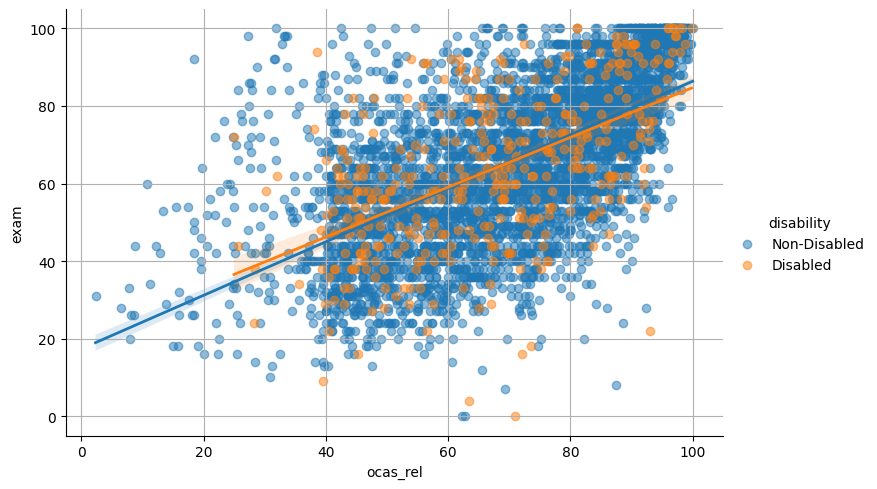

In [41]:
# for mod_pres in stud_course_all.mod_pres.unique():
#     print(mod_pres)
# display
import seaborn as sns

mod_pres = 'CCC_2013B'
# (
#     stud_course_all
#     .loc[lambda df_: df_.mod_pres == mod_pres]
#     .groupby(['gender'])
#       .plot(kind='scatter', x='ocas_rel',y='exam')
# )
df  =stud_course_all
plt.figure(figsize=(10, 6))

sns.lmplot(
    data=df, 
    x='ocas_rel', y='exam', 
    hue='disability', 
    aspect=1.5, 
    scatter_kws={'alpha':0.5},  # Adjust transparency of scatter points
    line_kws={'linewidth':2}    # Adjust the thickness of the regression line
)
plt.grid(True)

for gender in df['disability'].unique():
    subset = df[df['disability'] == gender]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['ocas_rel'], subset['exam'])
    
    print(f"Gender: {gender}")
    print(f"  Slope: {slope:.4f}")
    print(f"  Standard Error: {std_err:.4f}")
    print()


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1556737542.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ocas_rel_band'] = pd.cut(df.loc[:,'ocas_rel'], bins=bins, labels=labels, include_lowest=True)


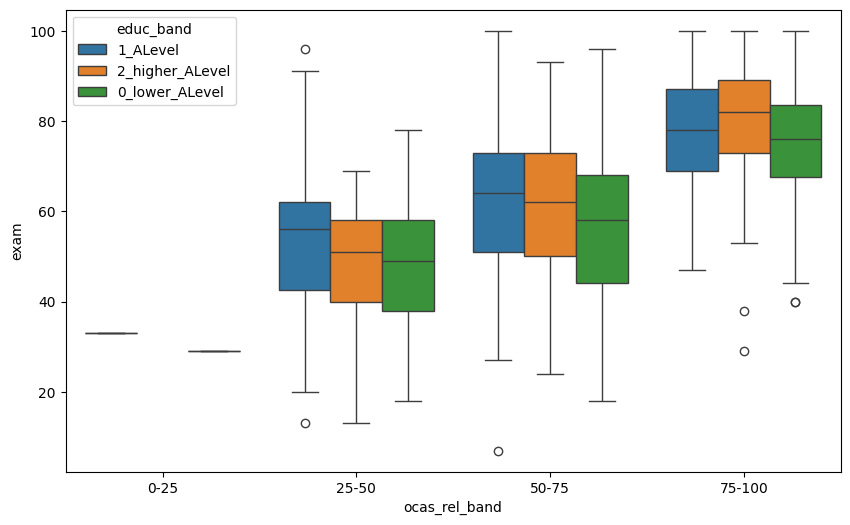

In [95]:
from scipy.stats import ttest_ind
import itertools
def plot_exam_per_group(df, mod_pres = 'CCC_2014J', group_col = 'disability'):
    # mod_pres = 'CCC_2014J'
    df = df.loc[lambda df_: df_['mod_pres'] == mod_pres]

    bins = [0, 20, 40, 60, 80, 100]
    bins = [0, 25, 50, 75, 100]
    # labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
    labels = ['0-25', '25-50', '50-75', '75-100']
    df['ocas_rel_band'] = pd.cut(df.loc[:,'ocas_rel'], bins=bins, labels=labels, include_lowest=True)

    plt.figure(figsize=(10, 6))

    # # Create the scatter plot with regression lines, colored by gender, and occluded by bands
    # sns.lmplot(
    #     data=df, 
    #     x='ocas_rel', y='exam', 
    #     # hue='gender', 
    #     col='ocas_rel_band',   # Facet the plot by the bands
    #     aspect=1.2, 
    #     scatter_kws={'alpha': 0.5},
    #     line_kws={'linewidth': 2}
    # )
    
    sns.boxplot(data=df, x='ocas_rel_band', y='exam', hue=group_col)

    significance_results = []
    for band in labels:
        df_band = df.loc[df['ocas_rel_band'] == band]
        
        # Separate data by gender within the band
        group_scores_all = dict()
        for grp in df_band[group_col].unique():
            group_scores = df_band[df_band[group_col] == grp]['exam']
            group_scores_all[grp] = group_scores
            # female_scores = df_band[df_band['disability'] == 'Non-Disabled']['exam']
        
        for grp1, grp2 in itertools.combinations(group_scores_all.keys(), 2):
            # print(combo)
            group_scores_1 = group_scores_all[grp1]
            group_scores_2 = group_scores_all[grp2]
            if len(group_scores_1) > 1 and len(group_scores_2) > 1:
                t_stat, p_value = ttest_ind(group_scores_1, group_scores_2, nan_policy='omit')
                significance_results.append((band, p_value))
            else:
                significance_results.append((band, None))
        # # Perform t-test if both groups have data
        # if len(male_scores) > 1 and len(female_scores) > 1:
        #     t_stat, p_value = ttest_ind(male_scores, female_scores, nan_policy='omit')
        #     significance_results.append((band, p_value))
        # else:
        #     significance_results.append((band, None))

    # print(significance_results)
    # # # # Annotate significance level on the plot
    # for idx, (band, p_value) in enumerate(significance_results):
    #     if p_value is not None:
    #         plt.text(idx, df['exam'].max() + 2, f'p={p_value:.3f}', 
    #                 horizontalalignment='center', color='black')
            
plot_exam_per_group(stud_course_all, mod_pres = 'DDD_2013J', group_col='educ_band')


## Assessment information

In [106]:
ass_export = (ass.
 reset_index()
 .loc[lambda df_: df_.code_module.isin(['CCC','DDD'])]
#  .loc[lambda df_: df_.assessment_type == 'TMA']
 [['code_module','code_presentation','assessment_name','weight','date','week']]
 .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)
 .sort_values(['code_module','code_presentation','assessment_name'])
)
ass_export.to_csv('../data/assessments.csv', index=False)

# One course improvement 

In [112]:
vle_all_2 = (vle_all
  .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)
#   .loc[lambda df_: df_.mod_pres == 'CCC_2014J']
#  .head()
)

In [408]:
# Nunique = 2302
def get_reg_stats(reg, df_courses):
    reg_2 = (reg   
    .reset_index()
    .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)
    )
    df_courses_2 = df_courses.reset_index().assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)

    reg_stat_daily_all = pd.DataFrame()
    reg_stat_weekly_all = pd.DataFrame()

    for mod_pres in reg_2.mod_pres.unique():
        # print(mod_pres)
        df_x = (reg_2
        .loc[lambda df_: df_.mod_pres == mod_pres]
        .drop(columns=['code_module','code_presentation','mod_pres'])
        .assign(date_unregistration = lambda df_: df_.date_unregistration.fillna(99999999.0))
        )

        max_actual_unregistration = df_x['date_unregistration'][df_x['date_unregistration'] < 99999999.0].max()
        module_presentation_length = df_courses_2.loc[lambda df_: df_.mod_pres == mod_pres].module_presentation_length.values[0]
        all_dates = pd.DataFrame({
            'date': range(1, int(module_presentation_length) + 1)
        })
        # all_dates
        all_dates['num_students_registered'] = all_dates['date'].apply(
            lambda x: ((df_x['date_registration'] <= x) & (df_x['date_unregistration'] >= x)).sum()
        )
        all_dates = (all_dates
                    .assign(mod_pres = mod_pres)
                    .assign(week = lambda df_: np.floor(df_.date / 7).astype(int))
        )
        all_dates_week = (all_dates
        # .assign(week = lambda df_: np.floor(df_.date / 7).astype(int))
        .sort_values(['date'])
        .groupby('week').first().drop(columns=['date'])
        #  .set_index('week')
        #  .plot()
        .reset_index()
        )

        reg_stat_daily_all = pd.concat([reg_stat_daily_all, all_dates])
        reg_stat_weekly_all = pd.concat([reg_stat_weekly_all, all_dates_week])
    return reg_stat_daily_all,  reg_stat_weekly_all

# course_length = dfs[DS_COURSES].module_presentation_length

# reg_stat_daily_all,  reg_stat_weekly_all = get_reg_stats(reg, dfs[DS_COURSES])
# reg_stat_daily_all.to_csv('../data/reg_stat_daily_all.csv', index=False)
# reg_stat_weekly_all.to_csv('../data/reg_stat_weekly_all.csv', index=False)

In [479]:
# reg_stat_daily_demog_all = pd.DataFrame()
reg_stat_weekly_demog_all = pd.DataFrame()

demog_2 = (demog
                .assign(credits_other_band = lambda df_: pd.cut(
                  df_.credits_other, bins=[0, 1, 60, 601], right=False)
                )
                .reset_index()
                .assign(age_band = lambda df_: df_.age_band.replace('55<=','35-55').str.replace('35-55','35+'))
            )
for col in [
    'gender',
    'disability','age_band','educ_band','is_repeating',
    'credits_other_band',
    'imd_2'
    ]:
    for val in demog_2[col].unique():
        print(col, val)
        reg_filt = (reg.reset_index()
                    .merge(demog_2)
                    .loc[lambda df_: df_[col] == val]
                    .set_index(['code_module','code_presentation'])
                    )
        print("- RegFilt", len(reg_filt))
        reg_stat_daily, reg_stat_weekly = get_reg_stats(reg_filt, dfs[DS_COURSES])
        reg_stat_weekly = reg_stat_weekly.assign(col = col, val=val)
        reg_stat_weekly_demog_all = pd.concat([reg_stat_weekly_demog_all, reg_stat_weekly], axis=0)
        # print(reg_stat_weekly_demog_all.groupby(["col","val"]).size())
        print("- len", len(reg_stat_weekly_demog_all), len(reg_stat_weekly))    

gender M
- RegFilt 17875
- len 817 817
gender F
- RegFilt 14718
- len 1634 817
disability N
- RegFilt 29429
- len 2451 817
disability Y
- RegFilt 3164
- len 3268 817
age_band 35+
- RegFilt 9649
- len 4085 817
age_band 0-35
- RegFilt 22944
- len 4902 817
educ_band 2_higher_ALevel
- RegFilt 5043
- len 5719 817
educ_band 1_ALevel
- RegFilt 14045
- len 6536 817
educ_band 0_lower_ALevel
- RegFilt 13505
- len 7353 817
is_repeating 0
- RegFilt 28421
- len 8170 817
is_repeating 1
- RegFilt 4172
- len 8836 666
credits_other_band [60, 601)
- RegFilt 9829
- len 9653 817
credits_other_band [0, 1)
- RegFilt 17015
- len 10470 817
credits_other_band [1, 60)
- RegFilt 5749
- len 11287 817
imd_2 Q4_Q5
- RegFilt 11082
- len 12104 817
imd_2 Q1_Q2
- RegFilt 14020
- len 12921 817
imd_2 Q3
- RegFilt 6380
- len 13738 817
imd_2 INT
- RegFilt 1111
- len 14555 817


In [269]:
# (stud_ass
#  .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)
# #  .loc[lambda df_: df_.mod_pres == 'CCC_2014J']
#  .assign(date_fill = lambda df_: df_.date.fillna(9999999))
#  .assign(submit_late = lambda df_: df_.date_submitted > df_.date_fill)
# #   .loc[lambda df_: df_.assessment_type == 'CMA']
#  .groupby(['mod_pres','assessment_name','week'])
#  ['submit_late'].mean().rename('pct_late')
#  .reset_index()
# #  .sort_values(by=['week'])
# #  .merge(all_dates_week, on=['week'])
# #  .assign(pct_submitted = lambda df_: df_.num_submitted / df_.num_students_registered)
# )

In [270]:
stud_ass_stats = (stud_ass
 .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)
#  .loc[lambda df_: df_.mod_pres == 'CCC_2014J']
 .assign(date_fill = lambda df_: df_.date.fillna(9999999))
 .assign(submit_late = lambda df_: df_.date_submitted > df_.date_fill)
  .groupby(['mod_pres','assessment_name','week'])
  .agg(num_submitted=('id_student','nunique'),
       pct_late = ('submit_late','mean'),
       avg_score = ('score','mean'),
       score_std = ('score','std'),
       
  )
 .reset_index()
 .merge(reg_stat_weekly_all, on=['mod_pres','week'])
 .assign(pct_submitted = lambda df_: df_.num_submitted / df_.num_students_registered)
 .sort_values(by=['mod_pres','week'])
)
stud_ass_stats.to_csv('../data/stud_ass_stats.csv', index=False)

In [486]:
# stud_ass_stats.head()


In [503]:
vle_weekly_demog_all = pd.DataFrame()
for mod_pres in vle_all_2.mod_pres.unique():
    for col in  ['gender','disability','age_band','educ_band','is_repeating','credits_other_band','imd_2']:
    # for col in  ['gender']:
        if 'CCC' not in mod_pres and 'DDD' not in mod_pres:
            continue
        # if mod_pres != 'CCC_2014J':
        #     continue
        print(mod_pres, col)
        reg_stat = (reg_stat_weekly_demog_all
            .loc[lambda df_: df_.mod_pres == mod_pres]
            .loc[lambda df_: df_["col"] == col]
        )
        stats = (vle_all_2
        .loc[lambda df_: df_.mod_pres == mod_pres]
        .drop(columns=['code_module','code_presentation'])
        .merge(demog
               .assign(credits_other_band = lambda df_: pd.cut(
                  df_.credits_other, bins=[0, 1, 60, 600], right=False)
                )
                .assign(age_band = lambda df_: df_.age_band.replace('55<=','35-55').str.replace('35-55','35+'))
            .reset_index()
            .assign(mod_pres = lambda df_: df_.code_module + '_' + df_.code_presentation)
            , on=['id_student','mod_pres'])
        .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')
        .reset_index()
        .merge(reg_stat, left_on=['mod_pres','week',col], right_on=['mod_pres','week','val'])
        .assign(pct_students = lambda df_: df_.num_students / df_.num_students_registered)
        .drop(columns=[col,'num_students_registered','num_students'])
        # .unstack()
        # .reset_index()
        # .merge(reg_stat_weekly_all, on=['mod_pres','week'])
        # .set_index(['mod_pres','week'])
        )
        # print(stats)
        # stats_by_type = (
        #     stats
        #     .iloc[:, :-1]
        #     .div(stats.num_students_registered, axis=0)
        #     # .reset_index()
        #     # .stack()
        #     .stack().rename('pct_students').reset_index()
        #     .assign(col = col)
        # )
        vle_weekly_demog_all = pd.concat([vle_weekly_demog_all, stats])

CCC_2014B gender
CCC_2014B disability
CCC_2014B age_band
CCC_2014B educ_band
CCC_2014B is_repeating
CCC_2014B credits_other_band


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1841753098.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')


CCC_2014B imd_2
CCC_2014J gender
CCC_2014J disability
CCC_2014J age_band
CCC_2014J educ_band
CCC_2014J is_repeating
CCC_2014J credits_other_band


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1841753098.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')


CCC_2014J imd_2
DDD_2013B gender
DDD_2013B disability
DDD_2013B age_band
DDD_2013B educ_band
DDD_2013B is_repeating
DDD_2013B credits_other_band


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1841753098.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')


DDD_2013B imd_2
DDD_2013J gender
DDD_2013J disability
DDD_2013J age_band
DDD_2013J educ_band
DDD_2013J is_repeating
DDD_2013J credits_other_band


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1841753098.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')


DDD_2013J imd_2
DDD_2014B gender
DDD_2014B disability
DDD_2014B age_band
DDD_2014B educ_band
DDD_2014B is_repeating
DDD_2014B credits_other_band


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1841753098.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')


DDD_2014B imd_2
DDD_2014J gender
DDD_2014J disability
DDD_2014J age_band
DDD_2014J educ_band
DDD_2014J is_repeating
DDD_2014J credits_other_band


C:\Users\martin.hlosta\AppData\Local\Temp\ipykernel_31928\1841753098.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['mod_pres','week',col])['id_student'].nunique().astype(int).rename('num_students')


DDD_2014J imd_2


In [504]:
# vle_weekly_demog_all.loc[lambda df_: df_.col == 'age_band'].val.value_counts()

In [505]:
vle_weekly_demog_all.to_csv('../data/vle_weekly_demog_all.csv', index=False)

In [357]:
# TO DASHBOARD
# vle_weekly_demog_all.loc[lambda df_: df_.col == 'gender'].drop(columns=['col']).set_index(['mod_pres','week','level_2']).unstack()['pct_students']

In [313]:
vle_weekly_all = pd.DataFrame()
for mod_pres in vle_all_2.mod_pres.unique():
    # if mod_pres != 'AAA_2013J':
    #     continue
    print(mod_pres)
    stats = (vle_all_2
    .loc[lambda df_: df_.mod_pres == mod_pres]
    .drop(columns=['code_module','code_presentation'])
    .groupby(['mod_pres','week'])['id_student'].nunique().astype(int).rename('pct_students')
    # .unstack()
    .reset_index()
    .merge(reg_stat_weekly_all, on=['mod_pres','week'])
    .set_index(['mod_pres','week'])
    )
    stats_by_type = (
        stats
        .iloc[:, :-1]
        .div(stats.num_students_registered, axis=0)
        .reset_index()
    )
    vle_weekly_all = pd.concat([vle_weekly_all, stats_by_type])

AAA_2013J
AAA_2014J
BBB_2013B
BBB_2013J
BBB_2014B
BBB_2014J
CCC_2014B
CCC_2014J
DDD_2013B
DDD_2013J
DDD_2014B
DDD_2014J
EEE_2013J
EEE_2014B
EEE_2014J
FFF_2013B
FFF_2013J
FFF_2014B
FFF_2014J
GGG_2013J
GGG_2014B
GGG_2014J


In [315]:
vle_weekly_all.to_csv('../data/vle_weekly_all.csv', index=False)

In [312]:
vle_weekly_all.head()

,mod_pres,week,pct_students
0,AAA_2013J,0.0,0.905914
1,AAA_2013J,1.0,0.914209
2,AAA_2013J,2.0,0.964865
3,AAA_2013J,3.0,0.822102
4,AAA_2013J,4.0,0.853659


In [303]:
vle_by_act_all = pd.DataFrame()
for mod_pres in vle_all_2.mod_pres.unique():
    print(mod_pres)
    stats = (vle_all_2
    .loc[lambda df_: df_.mod_pres == mod_pres]
    .drop(columns=['code_module','code_presentation'])
    #  .id_student.nunique()
    #  .head()
    .groupby(['mod_pres','week','activity_type'])['id_student'].nunique().astype(int).unstack()
    .reset_index()
    .merge(reg_stat_weekly_all, on=['mod_pres','week'])
    .set_index(['mod_pres','week'])
    #    .div(all_dates_week.set_index('week'))
    )
    stats_by_type = (
        stats
        .iloc[:, :-1]
        .div(stats.num_students_registered, axis=0)
        # .round(2)
        .reset_index()
    )
    vle_by_act_all = pd.concat([vle_by_act_all, stats_by_type])

AAA_2013J
AAA_2014J
BBB_2013B
BBB_2013J
BBB_2014B
BBB_2014J
CCC_2014B
CCC_2014J
DDD_2013B
DDD_2013J
DDD_2014B
DDD_2014J
EEE_2013J
EEE_2014B
EEE_2014J
FFF_2013B
FFF_2013J
FFF_2014B
FFF_2014J
GGG_2013J
GGG_2014B
GGG_2014J


In [306]:
vle_by_act_all.to_csv('../data/vle_by_act_all.csv', index=False)

In [67]:
(df
 .loc[lambda df_: df_.mod_pres == 'CCC_2014J']
 .head()

)

,code_module,code_presentation,id_student,date_submitted,is_banked,exam,exam_cutoff,assessment_name,exam_cutoff_week,gender,...,credits_other_band,mod_pres,is_pass,TMA 1,TMA 2,TMA 3,TMA 4,TMA 5,TMA 6,ocas_rel_band
621,CCC,2014J,559863,245,0,94.0,269.0,Exam,39,M,...,"[0, 1)",CCC_2014J,True,86.0,90.0,87.0,92.0,NaN,NaN,75-100
622,CCC,2014J,560064,244,0,24.0,269.0,Exam,39,M,...,"[0, 1)",CCC_2014J,False,84.0,59.0,46.0,38.0,NaN,NaN,50-75
623,CCC,2014J,560554,245,0,32.0,269.0,Exam,39,M,...,"[0, 1)",CCC_2014J,False,50.0,41.0,43.0,38.0,NaN,NaN,25-50
624,CCC,2014J,560784,244,0,38.0,269.0,Exam,39,M,...,"[0, 1)",CCC_2014J,False,62.0,32.0,37.0,56.0,NaN,NaN,25-50
625,CCC,2014J,560879,244,0,68.0,269.0,Exam,39,F,...,"[1, 60)",CCC_2014J,True,92.0,92.0,47.0,40.0,NaN,NaN,50-75
